In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [35]:
import tensorflow as tf

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, add
from tensorflow.keras.utils import plot_model

In [37]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']

In [38]:
df=pd.read_csv('fer2013.csv',names=names, na_filter=False)
df = df.iloc[1:]
df.head()

,emotion,pixels,usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [39]:
def get_train_data(df):
    x = []

    train = df['pixels'].to_numpy()

    for i in range(len(train)):
        x.append(train[i].split(' '))

    x = np.array(x)
    x = x.astype('float32').reshape(len(train), 48, 48, 1)

    return x

In [40]:
train = get_train_data(df)
labels = df['emotion'].to_numpy().astype('int')

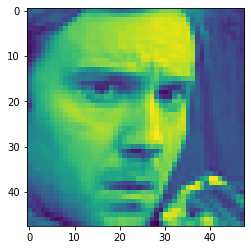

In [41]:
plt.imshow(train[0].reshape(48, 48))

In [42]:
labels[0]

0

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.33, random_state=42)

In [44]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [45]:
X_train.shape

(24044, 48, 48, 1)

In [46]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [47]:
time_callback_vgg = TimeHistory()
time_callback_resid = TimeHistory()

# VGG

In [48]:
def vgg_block(layer_in, n_filters, n_conv):
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

In [49]:
# define model input
visible = Input(shape=(48, 48, 1))
# add vgg module
layer = vgg_block(visible, 64, 2)
# add vgg module
layer = vgg_block(layer, 128, 2)
# add vgg module
layer = vgg_block(layer, 256, 4)

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_vgg = Model(inputs=visible, outputs=layer)
model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
model_vgg.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 128)       0   

In [53]:
history_vgg = model_vgg.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test), callbacks=[time_callback_vgg])

Epoch 1/3
752/752 [==============================] - 955s 1s/step - loss: 1.7490 - accuracy: 0.2851 - val_loss: 1.6568 - val_accuracy: 0.3432
Epoch 2/3
752/752 [==============================] - 953s 1s/step - loss: 1.5486 - accuracy: 0.3999 - val_loss: 1.5271 - val_accuracy: 0.4078
Epoch 3/3
752/752 [==============================] - 957s 1s/step - loss: 1.4031 - accuracy: 0.4626 - val_loss: 1.4038 - val_accuracy: 0.4620


# Residual Network

In [54]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

In [55]:
# define model input
visible = Input(shape=(48, 48, 1))
# add vgg module
layer = residual_module(visible, 64)
# create model

layer = Flatten()(layer)
layer = Dense(7, activation='softmax')(layer)

model_residual = Model(inputs=visible, outputs=layer)
model_residual.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
model_residual.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 48, 48, 64)   640         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 48, 48, 64)   36928       conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 48, 48, 64)   128         input_6[0][0]                    
____________________________________________________________________________________________

In [57]:
history_residual = model_residual.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test), callbacks=[time_callback_resid])

Epoch 1/3
752/752 [==============================] - 222s 295ms/step - loss: 58.3193 - accuracy: 0.2222 - val_loss: 1.8323 - val_accuracy: 0.2456
Epoch 2/3
752/752 [==============================] - 239s 317ms/step - loss: 1.7975 - accuracy: 0.2629 - val_loss: 1.8300 - val_accuracy: 0.2531
Epoch 3/3
752/752 [==============================] - 238s 317ms/step - loss: 1.7409 - accuracy: 0.2884 - val_loss: 1.8814 - val_accuracy: 0.2571


# Graphs

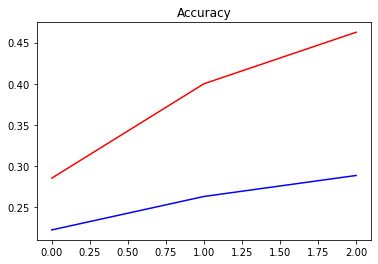

In [58]:
plt.title("Accuracy")
plt.plot(history_residual.history['accuracy'], 'b')
plt.plot(history_vgg.history['accuracy'], 'r')

VGG Accuracy is more than ResNet 

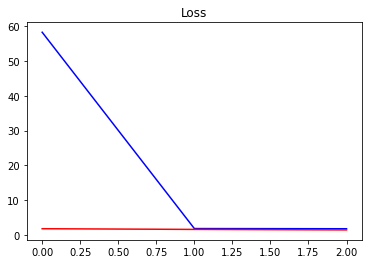

In [59]:
plt.title("Loss")
plt.plot(history_residual.history['loss'], 'b')
plt.plot(history_vgg.history['loss'], 'r')

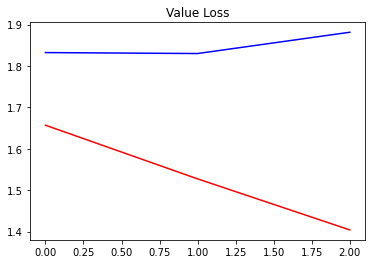

In [60]:
plt.title("Value Loss")
plt.plot(history_residual.history['val_loss'], 'b')
plt.plot(history_vgg.history['val_loss'], 'r')

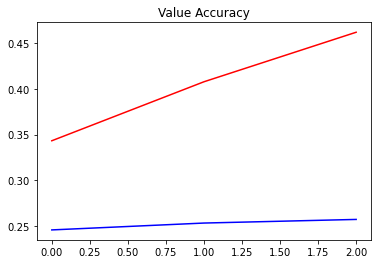

In [61]:
plt.title("Value Accuracy")
plt.plot(history_residual.history['val_accuracy'], 'b')
plt.plot(history_vgg.history['val_accuracy'], 'r')

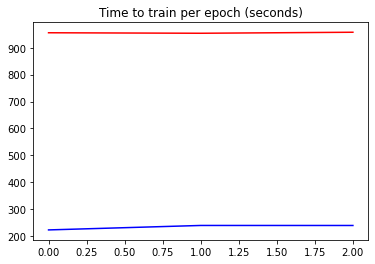

In [62]:
plt.title("Time to train per epoch (seconds)")
plt.plot(time_callback_resid.times, 'b')
plt.plot(time_callback_vgg.times, 'r')

ResNet epoch time is faster than VGG epoch time